In [59]:
from __future__ import absolute_import, division, print_function, unicode_literals

import glob
import math
import os
import tempfile

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle as pk
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.data import Dataset
import pathlib
import sklearn
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers
import matplotlib as mpl
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [60]:
mpl.rcParams['figure.figsize'] = (10, 8)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [61]:
data = pd.read_csv("fullfeature.csv")
data.head()

,fire_lat,fire_long,acq_hour,satellite,instrument,acq_daynight,subcell_id,fire_0d,township,date,...,fire_2d,fire_3d,subcell_fire_lat,subcell_fire_long,pheno1_long_dist,group1_size_dbef,reactivation,pheno2_close_dist,touched_phenom1,day_numb
0,0.0,0.0,0,0,0,0,T083R01_00,0,T083R01,02/05/2016,...,0,0,0.0,0.0,0,0.0,0,0,0,1
1,0.0,0.0,0,0,0,0,T083R01_01,0,T083R01,02/05/2016,...,0,0,0.0,0.0,0,0.0,0,0,0,1
2,0.0,0.0,0,0,0,0,T083R01_02,0,T083R01,02/05/2016,...,0,0,0.0,0.0,0,0.0,0,0,0,1
3,0.0,0.0,0,0,0,0,T083R01_03,0,T083R01,02/05/2016,...,0,0,0.0,0.0,0,0.0,0,0,0,1
4,0.0,0.0,0,0,0,0,T083R01_04,0,T083R01,02/05/2016,...,0,0,0.0,0.0,0,0.0,0,0,0,1


In [62]:
data = data.drop(["convdate", "date", "row", "column", "township", "satellite", "instrument",
                 "acq_daynight", "acq_hour", "subcell_id", "subcell_bound_up_long", "subcell_bound_down_long",
                 "subcell_bound_up_lat", "subcell_bound_down_lat", "cell_bound_up_long", "cell_bound_down_long",
                 "cell_bound_up_lat", "cell_bound_down_lat", "fire_long", "fire_lat", "group1_size_dbef",
                 "fire_2d", "touched_phenom1", "subcell_fire_long", "subcell_fire_lat", "day_numb", "fire_3d"],
                 axis = 1
                )
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146300 entries, 0 to 146299
Data columns (total 14 columns):
fire_0d                         146300 non-null int64
air_min_temp(°C)                146300 non-null float64
air_max_temp(°C)                146300 non-null float64
precipit(mm)                    146300 non-null float64
precipit_accumul(mm)            146300 non-null float64
avg_humidity(%)                 146300 non-null float64
computed_incoming_rad(MJ/m2)    146300 non-null float64
elevation(m)                    146300 non-null int64
interpol_wind_direct(°)         146300 non-null float64
aggreg_wind_veloc(km/h)         146300 non-null float64
fire_1d                         146300 non-null int64
pheno1_long_dist                146300 non-null int64
reactivation                    146300 non-null int64
pheno2_close_dist               146300 non-null int64
dtypes: float64(8), int64(6)
memory usage: 15.6 MB


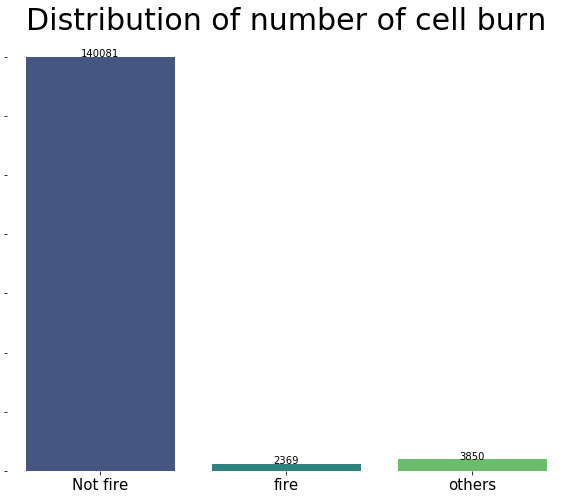

In [63]:
# using seaborns countplot to show distribution of classes in dataset

fig, ax = plt.subplots()
g = sns.countplot(data.fire_1d, palette = "viridis")
g.set_xticklabels(["Not fire", "fire", "others"])
g.set_yticklabels([])

# function to show values on bars
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = "{:.0f}".format(p.get_height())
            ax.text(_x, _y, value, ha = "center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title("Distribution of number of cell burn", fontsize = 30)
plt.tick_params(axis = "x", which = "major", labelsize = 15)
plt.show()

In [64]:
# Delete all observations with a class of 99

data = data[data["fire_1d"]!=99]
len(data[data["fire_1d"] == 99])

0

In [65]:
data["fire_1d"].value_counts()

0    140081
1      2369
Name: fire_1d, dtype: int64

In [66]:
# Examine the class label imbalance
# Let's look at the dataset imbalance:

not_fire, fire = np.bincount(data["fire_1d"])
total = not_fire + fire
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, fire, 100 * fire / total))

Examples:
    Total: 142450
    Positive: 2369 (1.66% of total)



In [67]:
# print(data["fire_0d"].value_counts())
# print(data["fire_1d"].value_counts())

In [68]:
data_inf = 23*3850
data_val_inf = 20*3850
data_sup = 23*3850  + 14*3850

col_day_one = ["fire_0d", "air_min_temp(°C)", "air_max_temp(°C)", "precipit(mm)",
          "precipit_accumul(mm)", "avg_humidity(%)", "computed_incoming_rad(MJ/m2)",
          "elevation(m)", "interpol_wind_direct(°)", "aggreg_wind_veloc(km/h)",
          "reactivation", "pheno2_close_dist", "pheno1_long_dist", "fire_1d"
         ]
train_1d = data.loc[:(data_inf-1), col_day_one]
train_val = data.loc[data_val_inf:(data_inf-1), col_day_one]
test_1d = data.loc[data_inf:(data_sup-1), col_day_one]

In [69]:
train_1d = train_1d.sort_index(ascending=[True])
train_val = train_val.sort_index(ascending=[True])
test_1d = test_1d.sort_index(ascending=[True])

train_1d = train_1d.reset_index(drop=True)
train_val = train_val.reset_index(drop=True)
test_1d = test_1d.reset_index(drop=True)

In [70]:
train_1d.shape, test_1d.shape, train_val.shape

((88550, 14), (53900, 14), (11550, 14))

In [71]:
# Separe categorical and numerical variables

# Define train numerical dataset for labels 
X_train_num_1d = train_1d.drop(["fire_0d", "fire_1d"], axis = 1)
X_train_val_num = train_val.drop(["fire_0d", "fire_1d"], axis = 1)
# Define train categorical dataset for labels
X_train_cat_1d = train_1d[["fire_0d", "fire_1d"]]
X_train_val_cat = train_val[["fire_0d", "fire_1d"]]

# Define test numerical dataset for labels 
X_test_num_1d = test_1d.drop(["fire_0d", "fire_1d"], axis = 1)

# Define test categorical dataset for labels
X_test_cat_1d = test_1d[["fire_0d", "fire_1d"]]

In [72]:
# Form np arrays of labels and features.

train_labels = np.array(train_1d.pop("fire_1d"))
bool_train_labels = train_labels != 0
val_labels = np.array(train_val.pop("fire_1d"))
test_labels = np.array(test_1d.pop("fire_1d"))

# Drop fire_0d from train, val and test set

popped_train = train_1d.drop(["fire_0d"], axis = 1)
popped_val = train_val.drop(["fire_0d"], axis = 1)
popped_test = test_1d.drop(["fire_0d"], axis = 1)

train_features = np.array(popped_train)
val_features = np.array(popped_val)
test_features = np.array(popped_test)

In [73]:
train_features.shape

(88550, 12)

Normalize the input features using the sklearn StandardScaler. This will set the mean to 0 and standard deviation to 1.

Note: The StandardScaler is only fit using the train_features to be sure the model is not peeking at the validation or test sets.

In [74]:
sc_x = StandardScaler()
train_features = sc_x.fit_transform(train_features)

val_features = sc_x.transform(val_features)
test_features = sc_x.transform(test_features)

#################### merge numerical and categorical variables of train data after transform ################## 
X_train_feat = pd.DataFrame(train_features, columns = X_train_num_1d.columns,
                           index=  X_train_num_1d.index
                           )
data_train_ = pd.merge(X_train_feat, X_train_cat_1d, right_index = True, left_index = True)
train_feat = data_train_.drop(["fire_1d"], axis = 1)

#################### merge numerical and categorical variables of val data after transform ##################
X_val_feat = pd.DataFrame(val_features, columns = X_train_val_num.columns,
                           index=  X_train_val_num.index
                           )
data_val_ = pd.merge(X_val_feat, X_train_val_cat, right_index = True, left_index = True)
val_feat = data_val_.drop(["fire_1d"], axis = 1)

#################### merge numerical and categorical variables of test data after transform ##################
X_test_feat = pd.DataFrame(test_features, columns = X_test_num_1d.columns,
                           index=  X_test_num_1d.index
                           )
data_test_ = pd.merge(X_test_feat, X_test_cat_1d, right_index = True, left_index = True)
test_feat = data_test_.drop(["fire_1d"], axis = 1)

# Given an interval, values outside the interval are clipped to the interval edges
train_feat = np.clip(train_feat, a_min = -2, a_max = 2)
val_feat = np.clip(val_feat, a_min = -2, a_max = 2)
test_feat = np.clip(test_feat, a_min = -2, a_max = 2)


print('Training labels shape is :', train_labels.shape)
print('\nValidation labels shape is :', val_labels.shape)
print('\nTest labels shape is :', test_labels.shape)

print('\nTraining features shape is :', train_feat.shape)
print('\nValidation features shape is :', val_feat.shape)
print('\nTest features shape is :', test_feat.shape)

Training labels shape is : (88550,)

Validation labels shape is : (11550,)

Test labels shape is : (53900,)

Training features shape is : (88550, 13)

Validation features shape is : (11550, 13)

Test features shape is : (53900, 13)


### Look at the data distribution
Next compare the distributions of the positive and negative examples over a few features. Good questions to ask yourself at this point are:

* Do these distributions make sense? 
    * Yes. You've normalized the input and these are mostly concentrated in the +/- 2 range.
* Can you see the difference between the ditributions?
    * Yes the positive examples contain a much higher rate of extreme values.

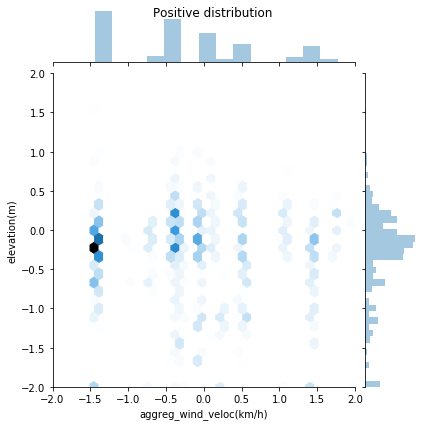

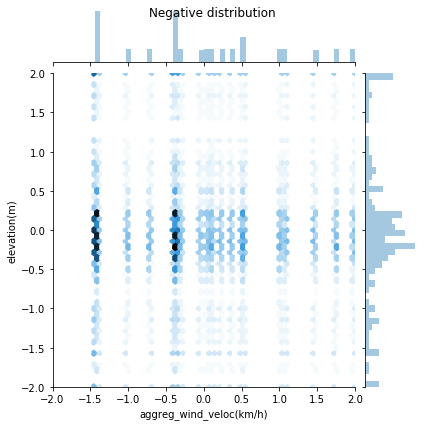

In [75]:
fire_df = train_feat[ bool_train_labels]
not_fire_df = train_feat[~bool_train_labels]

sns.jointplot(fire_df["aggreg_wind_veloc(km/h)"], fire_df["elevation(m)"],
              kind='hex', xlim = (-2,2), ylim = (-2,2))
plt.suptitle("Positive distribution")

sns.jointplot(not_fire_df["aggreg_wind_veloc(km/h)"], not_fire_df["elevation(m)"],
              kind='hex', xlim = (-2,2), ylim = (-2,2))
_ = plt.suptitle("Negative distribution")

In [76]:
# len(train_feat.keys())
# input_shape=(train_feat.shape[-1],)
# print(input_shape)


## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent:

In [77]:
METRICS = [
      keras.metrics.TruePositives(name = "TP"),
      keras.metrics.FalsePositives(name = "FP"),
      keras.metrics.TrueNegatives(name = "TN"),
      keras.metrics.FalseNegatives(name = "FN"), 
      keras.metrics.BinaryAccuracy(name = "accuracy"),
      keras.metrics.Precision(name = "precision"),
      keras.metrics.Recall(name = "recall"),
      keras.metrics.AUC(name = "auc"),
]

'''initial_learning_rate = 0.0001

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps = 6000,
    decay_rate = 0.95,
    staircase = True)'''

def make_model(metrics = METRICS, output_bias = None):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(32, activation = "relu", input_shape = (train_feat.shape[-1],)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(16, activation = "relu"),
        keras.layers.Dense(1, activation = "sigmoid", bias_initializer = output_bias),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr = 1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

## Baseline model
### Build the model
Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 11550, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.

Note: this model will not handle the class imbalance well. You will improve it later in this tutorial.

In [78]:
EPOCHS = 250
BATCH_SIZE = 11550

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_auc", 
    verbose = 1,
    patience = 20,
    mode= "max",
    restore_best_weights = True)

model = make_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                448       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________


Test run the model :

In [79]:
model.predict(train_feat[:10])

array([[0.68728155],
       [0.6873126 ],
       [0.6873126 ],
       [0.6873436 ],
       [0.6873436 ],
       [0.6873126 ],
       [0.6873126 ],
       [0.6873436 ],
       [0.6873436 ],
       [0.68737465]], dtype=float32)

These are initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that (See: [A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)). This can help with initial convergence.

With the default bias initialization the loss should be about `math.log(2) = 0.69314`

In [80]:
results = model.evaluate(train_feat, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.0754


The correct bias to set can be derived from:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [81]:
initial_bias = np.log([fire/not_fire])
initial_bias

array([-4.0797529])

Set that as the initial bias, and the model will give much more reasonable initial guesses. 

It should be near: `fire/total = 0.01663`

In [82]:
model = make_model(output_bias = initial_bias)
model.predict(train_feat[:10])

array([[0.03276581],
       [0.03275952],
       [0.03275952],
       [0.03275317],
       [0.03275317],
       [0.03275952],
       [0.03275952],
       [0.03275317],
       [0.03275321],
       [0.03274692]], dtype=float32)

With this initialization the initial loss should be approximately:

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [83]:
results = model.evaluate(train_feat, train_labels, batch_size = BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.1194


Cette perte initiale est environ 50 fois inférieure à ce qu'elle aurait été avec une initialisation naïve.

De cette façon, le modèle n'a pas besoin de passer les premières époques à apprendre que des exemples positifs sont peu probables. Cela facilite également la lecture des graphiques de la perte pendant l'entraînement.

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [84]:
initial_weights = os.path.join(tempfile.mkdtemp(), "initial_weights")
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses: 

In [85]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_feat,
    train_labels,
    batch_size = BATCH_SIZE,
    epochs = 20,
    validation_data = (val_feat, val_labels), 
    verbose = 0)

In [86]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_feat,
    train_labels,
    batch_size = BATCH_SIZE,
    epochs = 20,
    validation_data = (val_feat, val_labels), 
    verbose=0)

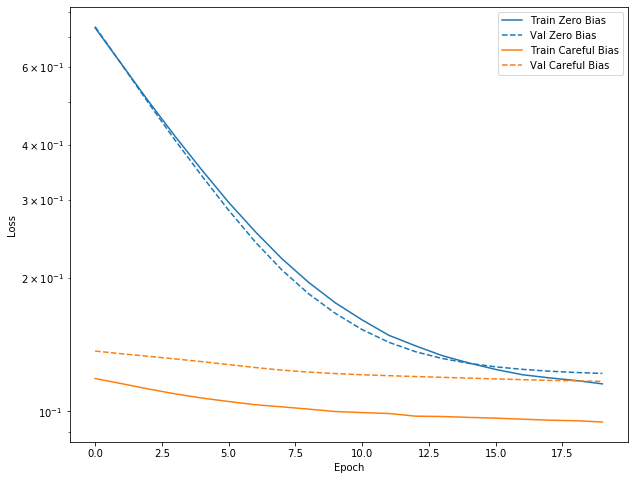

In [87]:
def plot_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
                 color = colors[n], label = 'Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
                 color = colors[n], label = 'Val '+label,
                 linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()
    
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [88]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_feat,
    train_labels,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [early_stopping],
    validation_data = (val_feat, val_labels))

Train on 88550 samples, validate on 11550 samples
Epoch 1/250
88550/88550 [==============================] - 1s 8us/sample - loss: 0.1185 - TP: 0.0000e+00 - FP: 0.0000e+00 - TN: 86277.0000 - FN: 2273.0000 - accuracy: 0.9743 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5894 - val_loss: 0.1370 - val_TP: 0.0000e+00 - val_FP: 0.0000e+00 - val_TN: 11192.0000 - val_FN: 358.0000 - val_accuracy: 0.9690 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5713
Epoch 2/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.1152 - TP: 0.0000e+00 - FP: 0.0000e+00 - TN: 86277.0000 - FN: 2273.0000 - accuracy: 0.9743 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6521 - val_loss: 0.1352 - val_TP: 0.0000e+00 - val_FP: 0.0000e+00 - val_TN: 11192.0000 - val_FN: 358.0000 - val_accuracy: 0.9690 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6091
Epoch 3/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.1125 - TP: 

88550/88550 [==============================] - 0s 3us/sample - loss: 0.0947 - TP: 119.0000 - FP: 89.0000 - TN: 86188.0000 - FN: 2154.0000 - accuracy: 0.9747 - precision: 0.5721 - recall: 0.0524 - auc: 0.8465 - val_loss: 0.1168 - val_TP: 0.0000e+00 - val_FP: 0.0000e+00 - val_TN: 11192.0000 - val_FN: 358.0000 - val_accuracy: 0.9690 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7648
Epoch 21/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0945 - TP: 108.0000 - FP: 111.0000 - TN: 86166.0000 - FN: 2165.0000 - accuracy: 0.9743 - precision: 0.4932 - recall: 0.0475 - auc: 0.8487 - val_loss: 0.1164 - val_TP: 0.0000e+00 - val_FP: 0.0000e+00 - val_TN: 11192.0000 - val_FN: 358.0000 - val_accuracy: 0.9690 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7757
Epoch 22/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0942 - TP: 114.0000 - FP: 106.0000 - TN: 86171.0000 - FN: 2159.0000 - accuracy: 0.9744 - precisi

Epoch 40/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0910 - TP: 141.0000 - FP: 114.0000 - TN: 86163.0000 - FN: 2132.0000 - accuracy: 0.9746 - precision: 0.5529 - recall: 0.0620 - auc: 0.8678 - val_loss: 0.1120 - val_TP: 0.0000e+00 - val_FP: 0.0000e+00 - val_TN: 11192.0000 - val_FN: 358.0000 - val_accuracy: 0.9690 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8126
Epoch 41/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0909 - TP: 125.0000 - FP: 102.0000 - TN: 86175.0000 - FN: 2148.0000 - accuracy: 0.9746 - precision: 0.5507 - recall: 0.0550 - auc: 0.8676 - val_loss: 0.1120 - val_TP: 0.0000e+00 - val_FP: 0.0000e+00 - val_TN: 11192.0000 - val_FN: 358.0000 - val_accuracy: 0.9690 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8161
Epoch 42/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0908 - TP: 136.0000 - FP: 108.0000 - TN: 86169.0000 - FN: 2137.0000 - accuracy: 0.

88550/88550 [==============================] - 0s 3us/sample - loss: 0.0889 - TP: 154.0000 - FP: 108.0000 - TN: 86169.0000 - FN: 2119.0000 - accuracy: 0.9749 - precision: 0.5878 - recall: 0.0678 - auc: 0.8776 - val_loss: 0.1086 - val_TP: 8.0000 - val_FP: 6.0000 - val_TN: 11186.0000 - val_FN: 350.0000 - val_accuracy: 0.9692 - val_precision: 0.5714 - val_recall: 0.0223 - val_auc: 0.8381
Epoch 61/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0889 - TP: 158.0000 - FP: 114.0000 - TN: 86163.0000 - FN: 2115.0000 - accuracy: 0.9748 - precision: 0.5809 - recall: 0.0695 - auc: 0.8783 - val_loss: 0.1084 - val_TP: 8.0000 - val_FP: 6.0000 - val_TN: 11186.0000 - val_FN: 350.0000 - val_accuracy: 0.9692 - val_precision: 0.5714 - val_recall: 0.0223 - val_auc: 0.8389
Epoch 62/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0890 - TP: 165.0000 - FP: 116.0000 - TN: 86161.0000 - FN: 2108.0000 - accuracy: 0.9749 - precision: 0.5872 - recall: 0.0726 - a

88550/88550 [==============================] - 0s 3us/sample - loss: 0.0877 - TP: 156.0000 - FP: 107.0000 - TN: 86170.0000 - FN: 2117.0000 - accuracy: 0.9749 - precision: 0.5932 - recall: 0.0686 - auc: 0.8838 - val_loss: 0.1061 - val_TP: 27.0000 - val_FP: 13.0000 - val_TN: 11179.0000 - val_FN: 331.0000 - val_accuracy: 0.9702 - val_precision: 0.6750 - val_recall: 0.0754 - val_auc: 0.8505
Epoch 81/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0874 - TP: 176.0000 - FP: 113.0000 - TN: 86164.0000 - FN: 2097.0000 - accuracy: 0.9750 - precision: 0.6090 - recall: 0.0774 - auc: 0.8859 - val_loss: 0.1062 - val_TP: 26.0000 - val_FP: 13.0000 - val_TN: 11179.0000 - val_FN: 332.0000 - val_accuracy: 0.9701 - val_precision: 0.6667 - val_recall: 0.0726 - val_auc: 0.8536
Epoch 82/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0875 - TP: 178.0000 - FP: 113.0000 - TN: 86164.0000 - FN: 2095.0000 - accuracy: 0.9751 - precision: 0.6117 - recall: 0.0783

88550/88550 [==============================] - 0s 3us/sample - loss: 0.0864 - TP: 175.0000 - FP: 111.0000 - TN: 86166.0000 - FN: 2098.0000 - accuracy: 0.9751 - precision: 0.6119 - recall: 0.0770 - auc: 0.8895 - val_loss: 0.1050 - val_TP: 34.0000 - val_FP: 17.0000 - val_TN: 11175.0000 - val_FN: 324.0000 - val_accuracy: 0.9705 - val_precision: 0.6667 - val_recall: 0.0950 - val_auc: 0.8602
Epoch 101/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0865 - TP: 183.0000 - FP: 122.0000 - TN: 86155.0000 - FN: 2090.0000 - accuracy: 0.9750 - precision: 0.6000 - recall: 0.0805 - auc: 0.8890 - val_loss: 0.1048 - val_TP: 39.0000 - val_FP: 18.0000 - val_TN: 11174.0000 - val_FN: 319.0000 - val_accuracy: 0.9708 - val_precision: 0.6842 - val_recall: 0.1089 - val_auc: 0.8582
Epoch 102/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0863 - TP: 172.0000 - FP: 106.0000 - TN: 86171.0000 - FN: 2101.0000 - accuracy: 0.9751 - precision: 0.6187 - recall: 0.07

88550/88550 [==============================] - 0s 3us/sample - loss: 0.0857 - TP: 166.0000 - FP: 115.0000 - TN: 86162.0000 - FN: 2107.0000 - accuracy: 0.9749 - precision: 0.5907 - recall: 0.0730 - auc: 0.8930 - val_loss: 0.1037 - val_TP: 40.0000 - val_FP: 18.0000 - val_TN: 11174.0000 - val_FN: 318.0000 - val_accuracy: 0.9709 - val_precision: 0.6897 - val_recall: 0.1117 - val_auc: 0.8650
Epoch 121/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0857 - TP: 172.0000 - FP: 125.0000 - TN: 86152.0000 - FN: 2101.0000 - accuracy: 0.9749 - precision: 0.5791 - recall: 0.0757 - auc: 0.8922 - val_loss: 0.1037 - val_TP: 40.0000 - val_FP: 18.0000 - val_TN: 11174.0000 - val_FN: 318.0000 - val_accuracy: 0.9709 - val_precision: 0.6897 - val_recall: 0.1117 - val_auc: 0.8653
Epoch 122/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0855 - TP: 188.0000 - FP: 110.0000 - TN: 86167.0000 - FN: 2085.0000 - accuracy: 0.9752 - precision: 0.6309 - recall: 0.08

88550/88550 [==============================] - 0s 3us/sample - loss: 0.0851 - TP: 177.0000 - FP: 114.0000 - TN: 86163.0000 - FN: 2096.0000 - accuracy: 0.9750 - precision: 0.6082 - recall: 0.0779 - auc: 0.8950 - val_loss: 0.1033 - val_TP: 24.0000 - val_FP: 10.0000 - val_TN: 11182.0000 - val_FN: 334.0000 - val_accuracy: 0.9702 - val_precision: 0.7059 - val_recall: 0.0670 - val_auc: 0.8679
Epoch 141/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0850 - TP: 184.0000 - FP: 127.0000 - TN: 86150.0000 - FN: 2089.0000 - accuracy: 0.9750 - precision: 0.5916 - recall: 0.0810 - auc: 0.8955 - val_loss: 0.1027 - val_TP: 40.0000 - val_FP: 18.0000 - val_TN: 11174.0000 - val_FN: 318.0000 - val_accuracy: 0.9709 - val_precision: 0.6897 - val_recall: 0.1117 - val_auc: 0.8672
Epoch 142/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0847 - TP: 195.0000 - FP: 128.0000 - TN: 86149.0000 - FN: 2078.0000 - accuracy: 0.9751 - precision: 0.6037 - recall: 0.08

88550/88550 [==============================] - 0s 3us/sample - loss: 0.0845 - TP: 170.0000 - FP: 140.0000 - TN: 86137.0000 - FN: 2103.0000 - accuracy: 0.9747 - precision: 0.5484 - recall: 0.0748 - auc: 0.8984 - val_loss: 0.1023 - val_TP: 33.0000 - val_FP: 14.0000 - val_TN: 11178.0000 - val_FN: 325.0000 - val_accuracy: 0.9706 - val_precision: 0.7021 - val_recall: 0.0922 - val_auc: 0.8716
Epoch 161/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0845 - TP: 180.0000 - FP: 113.0000 - TN: 86164.0000 - FN: 2093.0000 - accuracy: 0.9751 - precision: 0.6143 - recall: 0.0792 - auc: 0.8965 - val_loss: 0.1024 - val_TP: 24.0000 - val_FP: 10.0000 - val_TN: 11182.0000 - val_FN: 334.0000 - val_accuracy: 0.9702 - val_precision: 0.7059 - val_recall: 0.0670 - val_auc: 0.8731
Epoch 162/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0844 - TP: 196.0000 - FP: 111.0000 - TN: 86166.0000 - FN: 2077.0000 - accuracy: 0.9753 - precision: 0.6384 - recall: 0.08

88550/88550 [==============================] - 0s 3us/sample - loss: 0.0844 - TP: 186.0000 - FP: 111.0000 - TN: 86166.0000 - FN: 2087.0000 - accuracy: 0.9752 - precision: 0.6263 - recall: 0.0818 - auc: 0.8987 - val_loss: 0.1014 - val_TP: 24.0000 - val_FP: 10.0000 - val_TN: 11182.0000 - val_FN: 334.0000 - val_accuracy: 0.9702 - val_precision: 0.7059 - val_recall: 0.0670 - val_auc: 0.8769
Epoch 181/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0838 - TP: 193.0000 - FP: 128.0000 - TN: 86149.0000 - FN: 2080.0000 - accuracy: 0.9751 - precision: 0.6012 - recall: 0.0849 - auc: 0.9009 - val_loss: 0.1016 - val_TP: 24.0000 - val_FP: 10.0000 - val_TN: 11182.0000 - val_FN: 334.0000 - val_accuracy: 0.9702 - val_precision: 0.7059 - val_recall: 0.0670 - val_auc: 0.8780
Epoch 182/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0838 - TP: 194.0000 - FP: 116.0000 - TN: 86161.0000 - FN: 2079.0000 - accuracy: 0.9752 - precision: 0.6258 - recall: 0.08

88550/88550 [==============================] - 0s 3us/sample - loss: 0.0835 - TP: 190.0000 - FP: 114.0000 - TN: 86163.0000 - FN: 2083.0000 - accuracy: 0.9752 - precision: 0.6250 - recall: 0.0836 - auc: 0.9015 - val_loss: 0.1008 - val_TP: 24.0000 - val_FP: 10.0000 - val_TN: 11182.0000 - val_FN: 334.0000 - val_accuracy: 0.9702 - val_precision: 0.7059 - val_recall: 0.0670 - val_auc: 0.8788
Epoch 201/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0833 - TP: 196.0000 - FP: 131.0000 - TN: 86146.0000 - FN: 2077.0000 - accuracy: 0.9751 - precision: 0.5994 - recall: 0.0862 - auc: 0.9021 - val_loss: 0.1007 - val_TP: 33.0000 - val_FP: 13.0000 - val_TN: 11179.0000 - val_FN: 325.0000 - val_accuracy: 0.9707 - val_precision: 0.7174 - val_recall: 0.0922 - val_auc: 0.8781
Epoch 202/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0833 - TP: 188.0000 - FP: 121.0000 - TN: 86156.0000 - FN: 2085.0000 - accuracy: 0.9751 - precision: 0.6084 - recall: 0.08

88550/88550 [==============================] - 0s 3us/sample - loss: 0.0833 - TP: 196.0000 - FP: 130.0000 - TN: 86147.0000 - FN: 2077.0000 - accuracy: 0.9751 - precision: 0.6012 - recall: 0.0862 - auc: 0.9021 - val_loss: 0.1004 - val_TP: 24.0000 - val_FP: 10.0000 - val_TN: 11182.0000 - val_FN: 334.0000 - val_accuracy: 0.9702 - val_precision: 0.7059 - val_recall: 0.0670 - val_auc: 0.8804
Epoch 221/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0830 - TP: 201.0000 - FP: 128.0000 - TN: 86149.0000 - FN: 2072.0000 - accuracy: 0.9752 - precision: 0.6109 - recall: 0.0884 - auc: 0.9023 - val_loss: 0.1001 - val_TP: 33.0000 - val_FP: 13.0000 - val_TN: 11179.0000 - val_FN: 325.0000 - val_accuracy: 0.9707 - val_precision: 0.7174 - val_recall: 0.0922 - val_auc: 0.8819
Epoch 222/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0833 - TP: 199.0000 - FP: 147.0000 - TN: 86130.0000 - FN: 2074.0000 - accuracy: 0.9749 - precision: 0.5751 - recall: 0.08

88550/88550 [==============================] - 0s 4us/sample - loss: 0.0827 - TP: 213.0000 - FP: 126.0000 - TN: 86151.0000 - FN: 2060.0000 - accuracy: 0.9753 - precision: 0.6283 - recall: 0.0937 - auc: 0.9048 - val_loss: 0.0999 - val_TP: 33.0000 - val_FP: 13.0000 - val_TN: 11179.0000 - val_FN: 325.0000 - val_accuracy: 0.9707 - val_precision: 0.7174 - val_recall: 0.0922 - val_auc: 0.8833
Epoch 241/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0826 - TP: 213.0000 - FP: 123.0000 - TN: 86154.0000 - FN: 2060.0000 - accuracy: 0.9753 - precision: 0.6339 - recall: 0.0937 - auc: 0.9045 - val_loss: 0.0998 - val_TP: 33.0000 - val_FP: 15.0000 - val_TN: 11177.0000 - val_FN: 325.0000 - val_accuracy: 0.9706 - val_precision: 0.6875 - val_recall: 0.0922 - val_auc: 0.8838
Epoch 242/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.0830 - TP: 203.0000 - FP: 131.0000 - TN: 86146.0000 - FN: 2070.0000 - accuracy: 0.9751 - precision: 0.6078 - recall: 0.08

### Check training history
In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

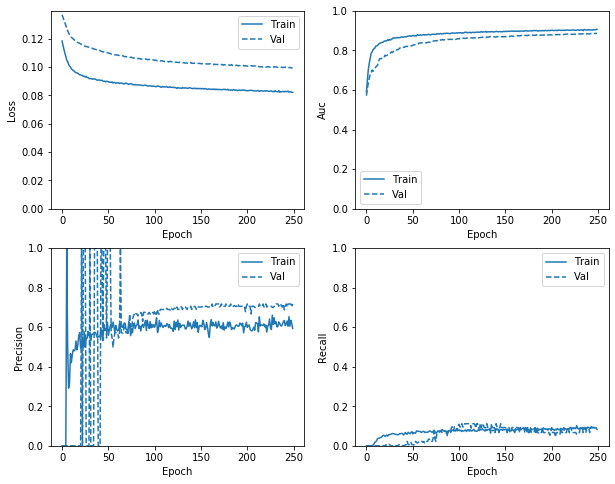

In [101]:
def plot_metrics(history):
    metrics =  ["loss", "auc", "precision", "recall"]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color = colors[0], label = 'Train')
        plt.plot(history.epoch, history.history['val_' + metric],
                 color = colors[0], linestyle = "--", label = 'Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0,1])
        else:
            plt.ylim([0,1])

        plt.legend()
    
plot_metrics(baseline_history)

### Evaluate metrics

You can use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels where the X axis is the predicted label and the Y axis is the actual label.

In [102]:
train_predictions_baseline = model.predict(train_feat, batch_size = BATCH_SIZE)
test_predictions_baseline = model.predict(test_feat, batch_size = BATCH_SIZE)

In [103]:
def plot_cm(labels, predictions, p = 0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize = (6,5))
    sns.heatmap(cm, annot = True, fmt = "d")
    plt.title("Confusion matrix @{:.2f}".format(p))
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")

    print("True Negatives: ", cm[0][0])
    print("False Positives: ", cm[0][1])
    print("False Negatives: ", cm[1][0])
    print("True Positives: ", cm[1][1])
    print("Total Fire cells: ", np.sum(cm[1]))

loss :  0.011212301493547525
TP :  0.0
FP :  0.0
TN :  53804.0
FN :  96.0
accuracy :  0.99821895
precision :  0.0
recall :  0.0
auc :  0.80521035

True Negatives:  53804
False Positives:  0
False Negatives:  96
True Positives:  0
Total Fire cells:  96


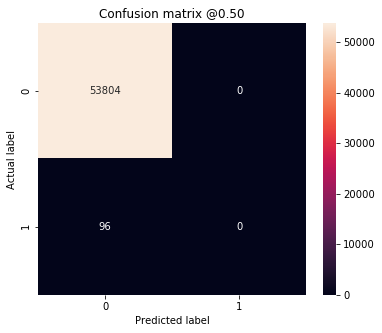

In [104]:
baseline_results = model.evaluate(test_feat, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

### Plot the ROC

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

In [113]:
def plot_roc(name, labels, predictions, **kwargs):
    FP, TP, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*FP, 100*TP, label = name, linewidth = 2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,87])
    plt.ylim([0,104])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

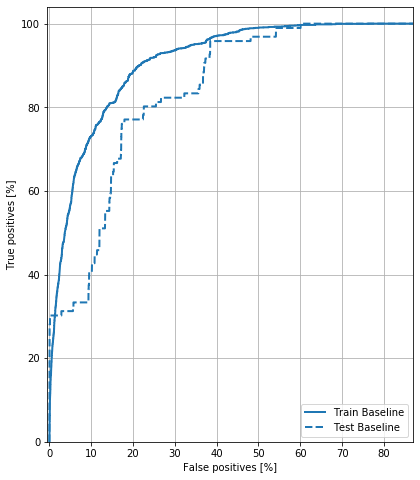

In [114]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc = 'lower right');

### 

## Class weights
### Calculate class weights

The goal is to identify fradulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [107]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / not_fire)*(total)/2.0 
weight_for_1 = (1 / fire)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 30.07


### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `optimizers.SGD`, may fail. The optimizer used here, `optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [108]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_feat,
    train_labels,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [early_stopping],
    validation_data = (val_feat, val_labels),
    # The class weights go here
    class_weight = class_weight) 

Train on 88550 samples, validate on 11550 samples
Epoch 1/250
88550/88550 [==============================] - 1s 6us/sample - loss: 2.8836 - TP: 0.0000e+00 - FP: 0.0000e+00 - TN: 86277.0000 - FN: 2273.0000 - accuracy: 0.9743 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5660 - val_loss: 0.1387 - val_TP: 0.0000e+00 - val_FP: 0.0000e+00 - val_TN: 11192.0000 - val_FN: 358.0000 - val_accuracy: 0.9690 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5413
Epoch 2/250
88550/88550 [==============================] - 0s 3us/sample - loss: 2.6236 - TP: 0.0000e+00 - FP: 0.0000e+00 - TN: 86277.0000 - FN: 2273.0000 - accuracy: 0.9743 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6026 - val_loss: 0.1428 - val_TP: 0.0000e+00 - val_FP: 0.0000e+00 - val_TN: 11192.0000 - val_FN: 358.0000 - val_accuracy: 0.9690 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5555
Epoch 3/250
88550/88550 [==============================] - 0s 3us/sample - loss: 2.3634 - TP: 

Epoch 21/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.7041 - TP: 1758.0000 - FP: 29009.0000 - TN: 57268.0000 - FN: 515.0000 - accuracy: 0.6666 - precision: 0.0571 - recall: 0.7734 - auc: 0.7889 - val_loss: 0.8578 - val_TP: 239.0000 - val_FP: 6037.0000 - val_TN: 5155.0000 - val_FN: 119.0000 - val_accuracy: 0.4670 - val_precision: 0.0381 - val_recall: 0.6676 - val_auc: 0.6478
Epoch 22/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.6951 - TP: 1759.0000 - FP: 28953.0000 - TN: 57324.0000 - FN: 514.0000 - accuracy: 0.6672 - precision: 0.0573 - recall: 0.7739 - auc: 0.7935 - val_loss: 0.8591 - val_TP: 239.0000 - val_FP: 6039.0000 - val_TN: 5153.0000 - val_FN: 119.0000 - val_accuracy: 0.4668 - val_precision: 0.0381 - val_recall: 0.6676 - val_auc: 0.6514
Epoch 23/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.6895 - TP: 1749.0000 - FP: 28919.0000 - TN: 57358.0000 - FN: 524.0000 - accuracy: 0.6675 - precision: 

88550/88550 [==============================] - 0s 3us/sample - loss: 0.6428 - TP: 1832.0000 - FP: 27216.0000 - TN: 59061.0000 - FN: 441.0000 - accuracy: 0.6877 - precision: 0.0631 - recall: 0.8060 - auc: 0.8234 - val_loss: 0.7927 - val_TP: 258.0000 - val_FP: 5706.0000 - val_TN: 5486.0000 - val_FN: 100.0000 - val_accuracy: 0.4973 - val_precision: 0.0433 - val_recall: 0.7207 - val_auc: 0.6942
Epoch 42/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.6406 - TP: 1811.0000 - FP: 27215.0000 - TN: 59062.0000 - FN: 462.0000 - accuracy: 0.6874 - precision: 0.0624 - recall: 0.7967 - auc: 0.8250 - val_loss: 0.7966 - val_TP: 258.0000 - val_FP: 5732.0000 - val_TN: 5460.0000 - val_FN: 100.0000 - val_accuracy: 0.4951 - val_precision: 0.0431 - val_recall: 0.7207 - val_auc: 0.6955
Epoch 43/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.6342 - TP: 1838.0000 - FP: 27180.0000 - TN: 59097.0000 - FN: 435.0000 - accuracy: 0.6881 - precision: 0.0633 - reca

88550/88550 [==============================] - 0s 3us/sample - loss: 0.5999 - TP: 1880.0000 - FP: 26351.0000 - TN: 59926.0000 - FN: 393.0000 - accuracy: 0.6980 - precision: 0.0666 - recall: 0.8271 - auc: 0.8436 - val_loss: 0.7406 - val_TP: 264.0000 - val_FP: 5221.0000 - val_TN: 5971.0000 - val_FN: 94.0000 - val_accuracy: 0.5398 - val_precision: 0.0481 - val_recall: 0.7374 - val_auc: 0.7285
Epoch 62/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.5986 - TP: 1901.0000 - FP: 26396.0000 - TN: 59881.0000 - FN: 372.0000 - accuracy: 0.6977 - precision: 0.0672 - recall: 0.8363 - auc: 0.8447 - val_loss: 0.7416 - val_TP: 264.0000 - val_FP: 5196.0000 - val_TN: 5996.0000 - val_FN: 94.0000 - val_accuracy: 0.5420 - val_precision: 0.0484 - val_recall: 0.7374 - val_auc: 0.7294
Epoch 63/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.5978 - TP: 1898.0000 - FP: 26322.0000 - TN: 59955.0000 - FN: 375.0000 - accuracy: 0.6985 - precision: 0.0673 - recall

88550/88550 [==============================] - 0s 3us/sample - loss: 0.5686 - TP: 1932.0000 - FP: 25892.0000 - TN: 60385.0000 - FN: 341.0000 - accuracy: 0.7037 - precision: 0.0694 - recall: 0.8500 - auc: 0.8579 - val_loss: 0.7065 - val_TP: 275.0000 - val_FP: 4751.0000 - val_TN: 6441.0000 - val_FN: 83.0000 - val_accuracy: 0.5815 - val_precision: 0.0547 - val_recall: 0.7682 - val_auc: 0.7613
Epoch 82/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.5771 - TP: 1918.0000 - FP: 25989.0000 - TN: 60288.0000 - FN: 355.0000 - accuracy: 0.7025 - precision: 0.0687 - recall: 0.8438 - auc: 0.8547 - val_loss: 0.7037 - val_TP: 274.0000 - val_FP: 4743.0000 - val_TN: 6449.0000 - val_FN: 84.0000 - val_accuracy: 0.5821 - val_precision: 0.0546 - val_recall: 0.7654 - val_auc: 0.7623
Epoch 83/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.5732 - TP: 1936.0000 - FP: 26044.0000 - TN: 60233.0000 - FN: 337.0000 - accuracy: 0.7021 - precision: 0.0692 - recall

88550/88550 [==============================] - 0s 3us/sample - loss: 0.5568 - TP: 1945.0000 - FP: 25731.0000 - TN: 60546.0000 - FN: 328.0000 - accuracy: 0.7057 - precision: 0.0703 - recall: 0.8557 - auc: 0.8632 - val_loss: 0.6739 - val_TP: 292.0000 - val_FP: 4360.0000 - val_TN: 6832.0000 - val_FN: 66.0000 - val_accuracy: 0.6168 - val_precision: 0.0628 - val_recall: 0.8156 - val_auc: 0.7881
Epoch 102/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.5556 - TP: 1963.0000 - FP: 25837.0000 - TN: 60440.0000 - FN: 310.0000 - accuracy: 0.7047 - precision: 0.0706 - recall: 0.8636 - auc: 0.8630 - val_loss: 0.6702 - val_TP: 291.0000 - val_FP: 4298.0000 - val_TN: 6894.0000 - val_FN: 67.0000 - val_accuracy: 0.6221 - val_precision: 0.0634 - val_recall: 0.8128 - val_auc: 0.7893
Epoch 103/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.5571 - TP: 1948.0000 - FP: 25633.0000 - TN: 60644.0000 - FN: 325.0000 - accuracy: 0.7069 - precision: 0.0706 - reca

88550/88550 [==============================] - 0s 3us/sample - loss: 0.5471 - TP: 1964.0000 - FP: 25543.0000 - TN: 60734.0000 - FN: 309.0000 - accuracy: 0.7081 - precision: 0.0714 - recall: 0.8641 - auc: 0.8664 - val_loss: 0.6465 - val_TP: 297.0000 - val_FP: 4041.0000 - val_TN: 7151.0000 - val_FN: 61.0000 - val_accuracy: 0.6448 - val_precision: 0.0685 - val_recall: 0.8296 - val_auc: 0.8109
Epoch 122/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.5416 - TP: 1969.0000 - FP: 25406.0000 - TN: 60871.0000 - FN: 304.0000 - accuracy: 0.7097 - precision: 0.0719 - recall: 0.8663 - auc: 0.8694 - val_loss: 0.6488 - val_TP: 297.0000 - val_FP: 4041.0000 - val_TN: 7151.0000 - val_FN: 61.0000 - val_accuracy: 0.6448 - val_precision: 0.0685 - val_recall: 0.8296 - val_auc: 0.8116
Epoch 123/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.5438 - TP: 1973.0000 - FP: 25647.0000 - TN: 60630.0000 - FN: 300.0000 - accuracy: 0.7070 - precision: 0.0714 - reca

88550/88550 [==============================] - 0s 3us/sample - loss: 0.5279 - TP: 2002.0000 - FP: 25485.0000 - TN: 60792.0000 - FN: 271.0000 - accuracy: 0.7091 - precision: 0.0728 - recall: 0.8808 - auc: 0.8751 - val_loss: 0.6218 - val_TP: 301.0000 - val_FP: 3886.0000 - val_TN: 7306.0000 - val_FN: 57.0000 - val_accuracy: 0.6586 - val_precision: 0.0719 - val_recall: 0.8408 - val_auc: 0.8311
Epoch 142/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.5231 - TP: 2009.0000 - FP: 25402.0000 - TN: 60875.0000 - FN: 264.0000 - accuracy: 0.7102 - precision: 0.0733 - recall: 0.8839 - auc: 0.8767 - val_loss: 0.6160 - val_TP: 301.0000 - val_FP: 3879.0000 - val_TN: 7313.0000 - val_FN: 57.0000 - val_accuracy: 0.6592 - val_precision: 0.0720 - val_recall: 0.8408 - val_auc: 0.8322
Epoch 143/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.5321 - TP: 1994.0000 - FP: 25379.0000 - TN: 60898.0000 - FN: 279.0000 - accuracy: 0.7102 - precision: 0.0728 - reca

88550/88550 [==============================] - 0s 3us/sample - loss: 0.5253 - TP: 2003.0000 - FP: 25752.0000 - TN: 60525.0000 - FN: 270.0000 - accuracy: 0.7061 - precision: 0.0722 - recall: 0.8812 - auc: 0.8760 - val_loss: 0.6198 - val_TP: 302.0000 - val_FP: 3967.0000 - val_TN: 7225.0000 - val_FN: 56.0000 - val_accuracy: 0.6517 - val_precision: 0.0707 - val_recall: 0.8436 - val_auc: 0.8417
Epoch 162/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.5197 - TP: 2016.0000 - FP: 25798.0000 - TN: 60479.0000 - FN: 257.0000 - accuracy: 0.7058 - precision: 0.0725 - recall: 0.8869 - auc: 0.8786 - val_loss: 0.6213 - val_TP: 302.0000 - val_FP: 3967.0000 - val_TN: 7225.0000 - val_FN: 56.0000 - val_accuracy: 0.6517 - val_precision: 0.0707 - val_recall: 0.8436 - val_auc: 0.8420
Epoch 163/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.5217 - TP: 2026.0000 - FP: 25585.0000 - TN: 60692.0000 - FN: 247.0000 - accuracy: 0.7083 - precision: 0.0734 - reca

88550/88550 [==============================] - 0s 3us/sample - loss: 0.5124 - TP: 2026.0000 - FP: 25539.0000 - TN: 60738.0000 - FN: 247.0000 - accuracy: 0.7088 - precision: 0.0735 - recall: 0.8913 - auc: 0.8826 - val_loss: 0.6178 - val_TP: 317.0000 - val_FP: 4103.0000 - val_TN: 7089.0000 - val_FN: 41.0000 - val_accuracy: 0.6412 - val_precision: 0.0717 - val_recall: 0.8855 - val_auc: 0.8491
Epoch 182/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.5107 - TP: 2034.0000 - FP: 25689.0000 - TN: 60588.0000 - FN: 239.0000 - accuracy: 0.7072 - precision: 0.0734 - recall: 0.8949 - auc: 0.8835 - val_loss: 0.6162 - val_TP: 317.0000 - val_FP: 4095.0000 - val_TN: 7097.0000 - val_FN: 41.0000 - val_accuracy: 0.6419 - val_precision: 0.0718 - val_recall: 0.8855 - val_auc: 0.8495
Epoch 183/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.5121 - TP: 2027.0000 - FP: 25241.0000 - TN: 61036.0000 - FN: 246.0000 - accuracy: 0.7122 - precision: 0.0743 - reca

88550/88550 [==============================] - 0s 3us/sample - loss: 0.4993 - TP: 2037.0000 - FP: 25504.0000 - TN: 60773.0000 - FN: 236.0000 - accuracy: 0.7093 - precision: 0.0740 - recall: 0.8962 - auc: 0.8880 - val_loss: 0.5997 - val_TP: 324.0000 - val_FP: 3988.0000 - val_TN: 7204.0000 - val_FN: 34.0000 - val_accuracy: 0.6518 - val_precision: 0.0751 - val_recall: 0.9050 - val_auc: 0.8559
Epoch 202/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.4999 - TP: 2041.0000 - FP: 25334.0000 - TN: 60943.0000 - FN: 232.0000 - accuracy: 0.7113 - precision: 0.0746 - recall: 0.8979 - auc: 0.8878 - val_loss: 0.5913 - val_TP: 324.0000 - val_FP: 3939.0000 - val_TN: 7253.0000 - val_FN: 34.0000 - val_accuracy: 0.6560 - val_precision: 0.0760 - val_recall: 0.9050 - val_auc: 0.8562
Epoch 203/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.5013 - TP: 2041.0000 - FP: 25349.0000 - TN: 60928.0000 - FN: 232.0000 - accuracy: 0.7111 - precision: 0.0745 - reca

88550/88550 [==============================] - 0s 3us/sample - loss: 0.4960 - TP: 2045.0000 - FP: 25115.0000 - TN: 61162.0000 - FN: 228.0000 - accuracy: 0.7138 - precision: 0.0753 - recall: 0.8997 - auc: 0.8893 - val_loss: 0.5875 - val_TP: 323.0000 - val_FP: 3870.0000 - val_TN: 7322.0000 - val_FN: 35.0000 - val_accuracy: 0.6619 - val_precision: 0.0770 - val_recall: 0.9022 - val_auc: 0.8592
Epoch 222/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.4943 - TP: 2059.0000 - FP: 25110.0000 - TN: 61167.0000 - FN: 214.0000 - accuracy: 0.7140 - precision: 0.0758 - recall: 0.9059 - auc: 0.8911 - val_loss: 0.5992 - val_TP: 324.0000 - val_FP: 3911.0000 - val_TN: 7281.0000 - val_FN: 34.0000 - val_accuracy: 0.6584 - val_precision: 0.0765 - val_recall: 0.9050 - val_auc: 0.8598
Epoch 223/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.4950 - TP: 2064.0000 - FP: 25268.0000 - TN: 61009.0000 - FN: 209.0000 - accuracy: 0.7123 - precision: 0.0755 - reca

88550/88550 [==============================] - 0s 3us/sample - loss: 0.4952 - TP: 2063.0000 - FP: 25715.0000 - TN: 60562.0000 - FN: 210.0000 - accuracy: 0.7072 - precision: 0.0743 - recall: 0.9076 - auc: 0.8904 - val_loss: 0.5938 - val_TP: 330.0000 - val_FP: 3956.0000 - val_TN: 7236.0000 - val_FN: 28.0000 - val_accuracy: 0.6551 - val_precision: 0.0770 - val_recall: 0.9218 - val_auc: 0.8629
Epoch 242/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.4993 - TP: 2042.0000 - FP: 25323.0000 - TN: 60954.0000 - FN: 231.0000 - accuracy: 0.7114 - precision: 0.0746 - recall: 0.8984 - auc: 0.8886 - val_loss: 0.5797 - val_TP: 329.0000 - val_FP: 3800.0000 - val_TN: 7392.0000 - val_FN: 29.0000 - val_accuracy: 0.6685 - val_precision: 0.0797 - val_recall: 0.9190 - val_auc: 0.8634
Epoch 243/250
88550/88550 [==============================] - 0s 3us/sample - loss: 0.4945 - TP: 2053.0000 - FP: 25349.0000 - TN: 60928.0000 - FN: 220.0000 - accuracy: 0.7112 - precision: 0.0749 - reca

### Check training history

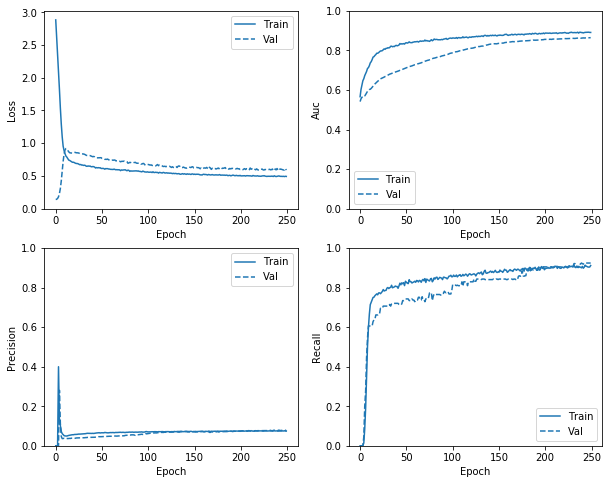

In [109]:
plot_metrics(weighted_history)

### Evaluate metrics

In [110]:
train_predict_weighted = weighted_model.predict(train_feat, batch_size = BATCH_SIZE)
test_predict_weighted = weighted_model.predict(test_feat, batch_size = BATCH_SIZE)

loss :  0.32626849439527306
TP :  75.0
FP :  12093.0
TN :  41711.0
FN :  21.0
accuracy :  0.77525043
precision :  0.006163708
recall :  0.78125
auc :  0.83926445

True Negatives:  41711
False Positives:  12093
False Negatives:  21
True Positives:  75
Total Fire cells:  96


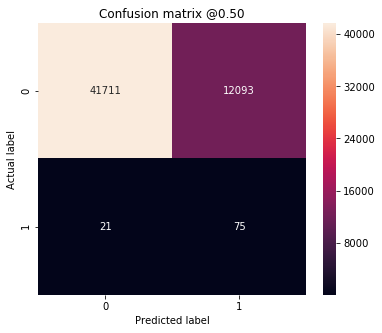

In [111]:
weighted_results = weighted_model.evaluate(test_feat, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predict_weighted)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more cells on fire).

### Plot the ROC

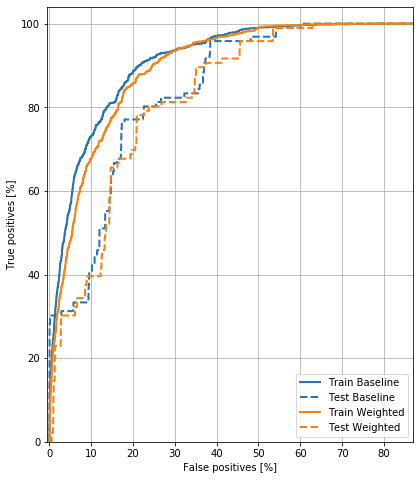

In [115]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color = colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color = colors[0], linestyle = '--')

plot_roc("Train Weighted", train_labels, train_predict_weighted, color = colors[1])
plot_roc("Test Weighted", test_labels, test_predict_weighted, color = colors[1], linestyle = '--')

plt.legend(loc='lower right');

### Les prédictions sont plutôt bonnes avec une "auc" à 83,9 %, le modèle fait mieux que le hazard 